## AtmoBuilder / Atmo Tutorial

Sections:
- [Prerequisites and Installation](#Prerequisites-and-Installation)
- [Background Science and Equations](#Background-Science-and-Equations)
- [The Basics: Initialize AtmoBuilder](#The-Basics:-Initialize-the-AtmoBuilder-class)
- [The Basics: Atmo Object](#The-Basics:-Atmo-Class)
- [The Basics: SED Types](#The-Basics:-SED-Types)
- [The Basics: Simple Operations](#The-Basics:-Simple-Operations)
- [Regressions: Two Parameters](#Regressions:-Two-Parameters)

### Prerequisites and Installation

If you are viewing this notebook through notebookviewer online and wish to install and use AtmoBuilder then please clone the [github repository](#https://github.com/moeyensj/atmo2mags) to get started.

AtmoBuilder requires the following to installed and appropriately sourced (including all pre-requisite software):
    - LSST Software Stack
        - sims_photUtils
        - sims_sed_library
    - AstroML

AtmoBuilder's wavelength gridding is limited by the availabe MODTRAN data, as a result this requires the photometricDefaults.py in sims_photUtils to be altered as follows:

Stack Default:  
    - minwavelen = 300
    - maxwavelen = 1150.1
    - wavelenstep = 0.1
    
Required by AtmoBuilder:
    - minwavelen = 300
    - maxwavelen = 1100.5
    - wavelenstep = 0.5
   
In the future this step may not be necessary, keep an eye out on updates to the github repository!

### Background Science and Equations

Atmospheric extinction can be modeled by 5 individual components: molecular (Rayleigh) scattering, 
aerosol (Mie) scattering, molecular absorption by ozone (O$_3$), water vapor and combined O$_2$ trace species (see Section 5.2 in LSST document LSE-180):

$S^{atm}(\lambda) = \Pi_{k=1}^5 \, {\rm e}^{- t_k \, \tau_k^{std}(\lambda, X)} 
                           =  {\rm e}^{-\sum_{k=1}^5  t_k \, \tau_k^{std}(\lambda, X)}$

Here $X$ is airmass, $t_k$ is the ratio of the column density (or optical depth) of the $k$-th 
component and its value for the standard atmosphere, and $\tau_k^{std}(\lambda, X)$ is the 
wavelength-dependent optical depth of the $k$-th component for the standard 
atmosphere (with $t_k=1$) viewed at airmass $X$. 

Aerosol (Mie) scattering data is not provided with MODTRAN data and has been modeled with a power-law relationship:

$ \tau_{aerosol}(\lambda, X, \alpha) = 0.1 \, X \, \left({550 \, {\rm nm} \over \lambda} \right)^\alpha $

The power-law exponent ($\alpha$) is chosen to be the 6th free parameter when modeling atmospheres. In summation, we can define a single parameter array of $t_k$ values for each of the 5 extincton components and 1 for the power-law exponent:

$ [t_{H_2O}, t_{O_2}, t_{O_3}, t_{Rayleigh}, t_{Aerosol}, t_{\alpha}] $

The standard atmosphere is defined by the following parameter array and airmass:

    - P: [1.0,1.0,1.0,1.0,1.0,1.7]
    - X: 1.2
    
In order to create an atmosphere for use with AtmoBuilder, a parameter array and airmass like the one above must be given. Details on the specific procedure can be found in the following sections.

### The Basics: Initialize AtmoBuilder

Importing the AtmoBuilder class:

In [1]:
from AtmoBuilder import AtmoBuilder

% matplotlib inline

Initializing the class:

In [2]:
ab = AtmoBuilder()

Found 16 MODTRAN files:
Pachon_MODTRAN.10.7sc
Pachon_MODTRAN.11.7sc
Pachon_MODTRAN.12.7sc
Pachon_MODTRAN.13.7sc
Pachon_MODTRAN.14.7sc
Pachon_MODTRAN.15.7sc
Pachon_MODTRAN.16.7sc
Pachon_MODTRAN.17.7sc
Pachon_MODTRAN.18.7sc
Pachon_MODTRAN.19.7sc
Pachon_MODTRAN.20.7sc
Pachon_MODTRAN.21.7sc
Pachon_MODTRAN.22.7sc
Pachon_MODTRAN.23.7sc
Pachon_MODTRAN.24.7sc
Pachon_MODTRAN.25.7sc
MODTRAN files have been read.

Read filter data from LSST software stack.
Filters: ['u', 'g', 'r', 'i', 'z', 'y4']
Read hardware data from LSST software stack.


When initialized AtmoBuilder will output the code above to notify you that it has found and read MODTRAN data, and that it has found filter and hardware data from the LSST software stack. 

Retrieving MODTRAN data:

In [3]:
# List of read airmasses
ab.airmasses

['1.000',
 '1.100',
 '1.200',
 '1.300',
 '1.400',
 '1.500',
 '1.600',
 '1.700',
 '1.800',
 '1.900',
 '2.000',
 '2.100',
 '2.200',
 '2.300',
 '2.400',
 '2.500']

In [4]:
# Standard transmission profile keyed to airmass and component
ab.transDict[1.2]['Rayleigh']

array([ 0.    ,  0.3524,  0.3551, ...,  0.9949,  0.9949,  0.9949])

Plotting the filter and hardware response curves (hardware includes filters):

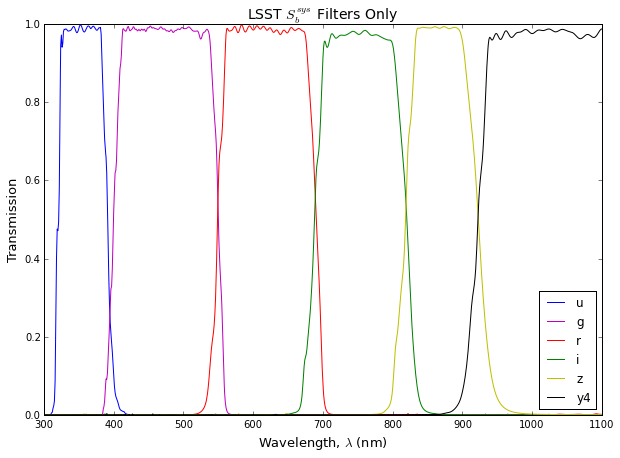

In [5]:
ab.filterPlot()

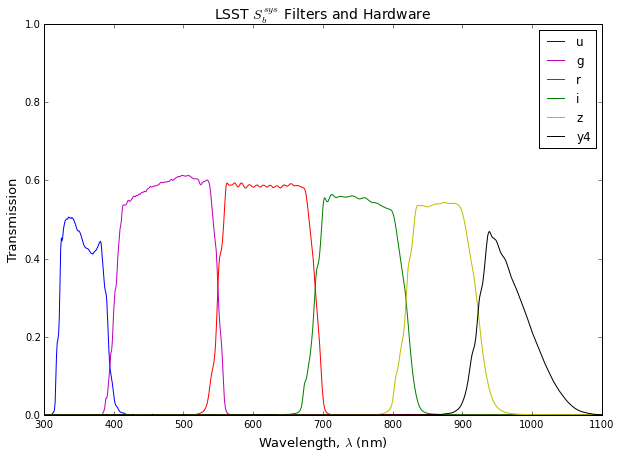

In [6]:
ab.hardwarePlot()

### The Basics: Atmo Class

AtmoBuilder utilizes an independent atmo object which keeps track of several useful elements. Let's start by creating two atmospheres:

In [7]:
atmo = ab.buildAtmo([1.0,1.0,1.0,2.2,1.4,1.7],1.4)
atmo_std = ab.buildAtmo([1.0,1.0,1.0,1.0,1.0,1.7],1.2)

The line of code above has two important keyword parameters:
    - P: parameter array containing 6 values, one for each of the atmospheric extinction components
    - X: airmass

Retrieving atmo attributes:

In [8]:
# Parameters and airmass
atmo.P, atmo.X

([1.0, 1.0, 1.0, 2.2, 1.4, 1.7], 1.4)

In [9]:
# Total transmission [array]
atmo.sb

array([  0.00000000e+00,   5.62775604e-04,   7.80424731e-04, ...,
         7.95777857e-01,   7.87900709e-01,   7.91135642e-01])

In [10]:
# Individual component transmission profiles [component-keyed dictionary]
atmo.sbDict

{'Aerosol': array([ 0.54288017,  0.54343224,  0.54398304, ...,  0.84640984,
         0.84647403,  0.84653816]),
 'H2O': array([ 0.    ,  1.    ,  1.    , ...,  0.9525,  0.943 ,  0.9468]),
 'O2': array([ 0.,  1.,  1., ...,  1.,  1.,  1.]),
 'O3': array([ 0.    ,  0.015 ,  0.0204, ...,  1.    ,  1.    ,  1.    ]),
 'Rayleigh': array([ 0.        ,  0.06903965,  0.07032593, ...,  0.98706593,
         0.98706593,  0.98706593])}

AtmoBuilder has a lot of various plotting functions including one for atmospheres. The following function will take an atmo object and plot its transmission profile:

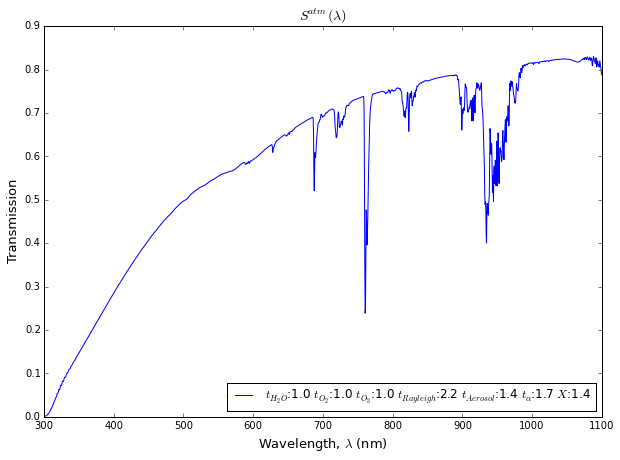

In [11]:
ab.transPlot(atmo)

AtmoBuilder can also plot the individual components:

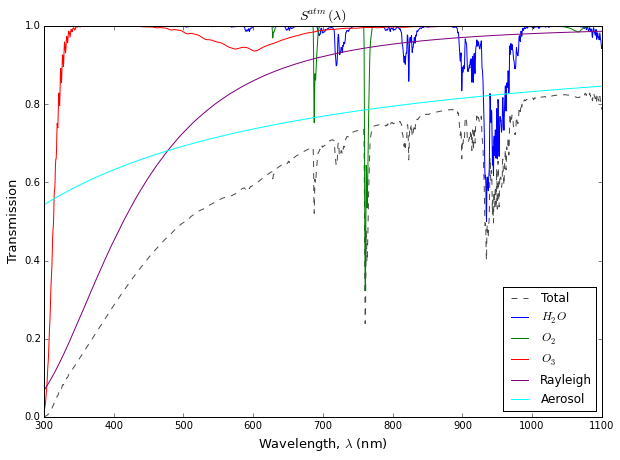

In [12]:
ab.transPlot(atmo, includeComponents=True)

Want to compare the atmosphere to another atmosphere?

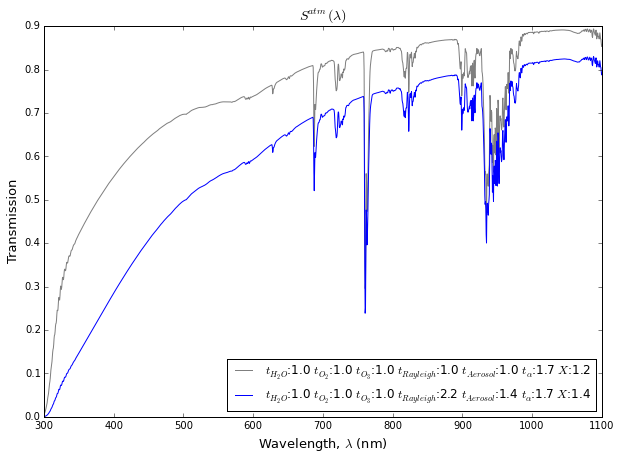

In [13]:
ab.transPlot(atmo, atmo2=atmo_std)

Of course, keeping track of a standard atmosphere like the one we created can become laborious. To avoid this, internally in AtmoBuilder there are class constants which define the parameters and airmass for a standard atmosphere. For all major functionality you need not worry about keeping track of the the standard atmosphere. For example:

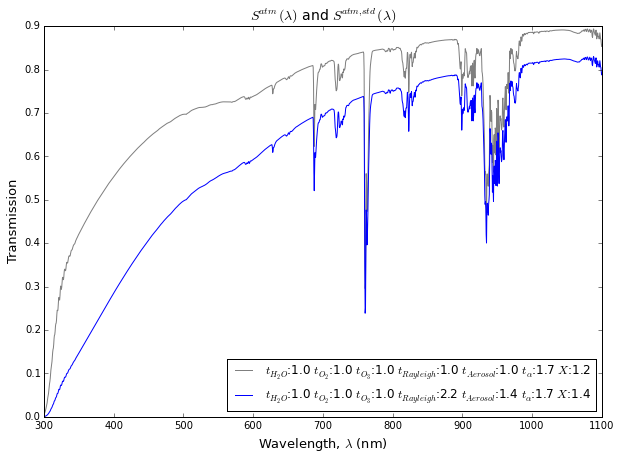

In [14]:
ab.transPlot(atmo,includeStdAtmo=True)

### The Basics: SED Types

In order to run regressions and to use many of the basic operations and functions in AtmoBuilder we need SED data to be read in. This is not done when the class is initialized because it can take a fair amount of time depending on how many SEDs you want to read in.

By default AtmoBuilder uses six SED types:
    - Kurucz Main Sequence Stars (read from LSST's SED library) ['mss']
    - White Dwarf Stars (read from LSST's SED library) ['wds']
    - Galaxies (generated at different redshifts from LSST's SED library) ['gals']
    - MLT Dwarf Stars (read from LSST's SED library) ['mlts']
    - Quasars (generated at different redshifts from AtmoBuilder repository) ['qsos']
    - Supernovae (generated at different redshifts from AtmoBuilder repository) ['sns']

Reading in Kurucz MS stars:

In [15]:
ab.readMSs()

# Read 988 MS stars from /Users/joachim/lsst/DarwinX86/sims_sed_library/2014.10.06/starSED/kurucz/


You can call similar functions for each of the six SED types to read them. If you want to use all of the available SED types (or a large subset) you can call the following (this will take a little bit of time):

In [16]:
ab.readAll()

# Read 988 MS stars from /Users/joachim/lsst/DarwinX86/sims_sed_library/2014.10.06/starSED/kurucz/
# Read 849 white dwarfs from /Users/joachim/lsst/DarwinX86/sims_sed_library/2014.10.06/starSED/wDs/
# Read 74 mlt stars from /Users/joachim/lsst/DarwinX86/sims_sed_library/2014.10.06/starSED/mlt/
# Generated 2520 galaxies at redshifts between 0.000000 and 3.000000
# Generated 76 quasars at redshifts between 0.000000 and 7.500000
# Generated 39 sn's at redshifts between 0.000000 and 1.200000 on days ['0', '20', '40']


If you want to run some simple operations it may be helpful to retrieve the SED data you read in. With AtmoBuilder it is remarkably easy to do so as it is all stored as class attributes. Lets retrieve some quasar data:

In [17]:
qso = ab.qsos
qso_z = ab.qsoRedshifts

We can see what the SED attributes are set when SED data is read in two ways:

In [18]:
ab?

... or we can look at each of the individual SED read functions:

In [19]:
ab.readMSs?

### The Basics: Simple Operations

Once you have some SED data read in you can use them to calculate magnitudes, delta magnitudes, and so on... 

Lets combine hardware data and an atmosphere object to get the combined throughput:

In [20]:
throughput = ab.combineThroughputs(atmo)
throughput_std = ab.combineThroughputs(atmo_std)

We can then also plot the combined throughput:

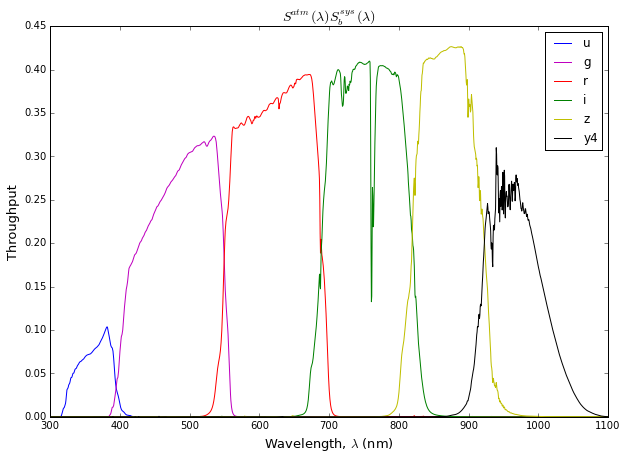

In [21]:
ab.throughputPlot(throughput)

Like transPlot, we can plot two throughputs or include the standard throughput:

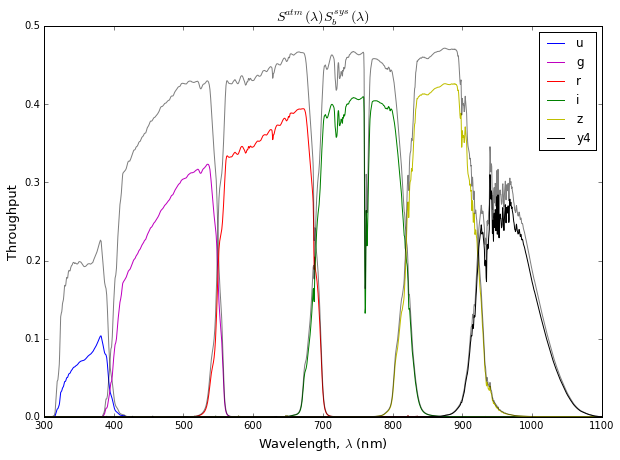

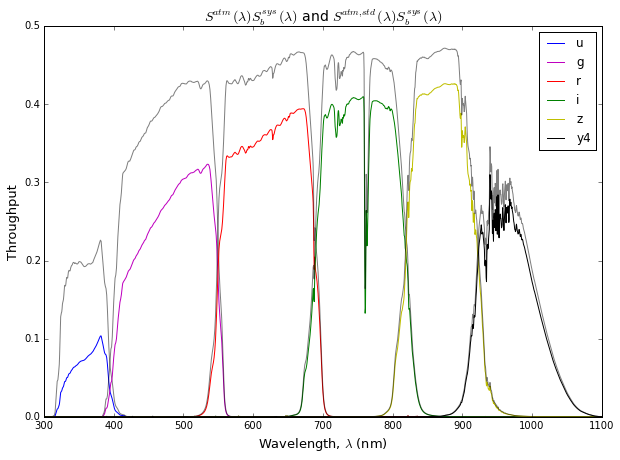

In [22]:
ab.throughputPlot(throughput, bpDict2=throughput_std)
ab.throughputPlot(throughput, includeStdAtmo=True)

A characteristic function we care about is the normalized bandpass response function for a given throughput. The phi function can be retrieved from a filter-keyed bandpass dictionary as follows (example for u filter):

In [23]:
throughput['u'].phi

array([  0.00000000e+00,   2.41980424e-10,   6.86163658e-10, ...,
         4.21530335e-10,   3.53349898e-10,   2.86675661e-10])

Because these throughputs are bandpass objects, you can also access the wavelength range and the overall throughput:

In [24]:
throughput['u'].sb

array([  0.00000000e+00,   1.06043522e-09,   3.01199080e-09, ...,
         6.75594271e-09,   5.66577908e-09,   4.59878324e-09])

In [25]:
throughput['u'].wavelen

array([  300. ,   300.5,   301. , ...,  1099. ,  1099.5,  1100. ])

AtmoBuilder can also plot phi functions:

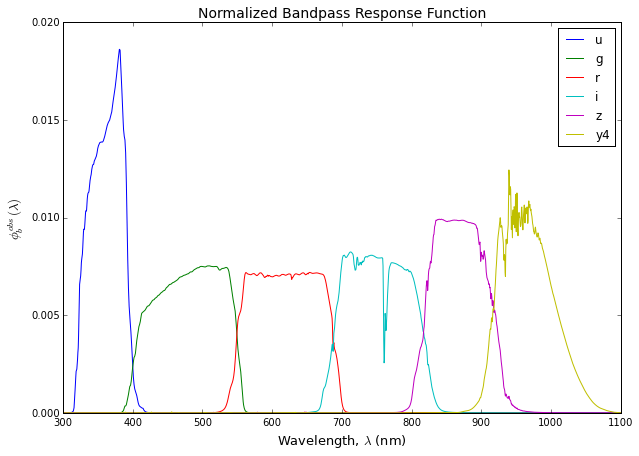

In [26]:
ab.phiPlot(throughput)

Of course it might be handy to compare one phi function to another:

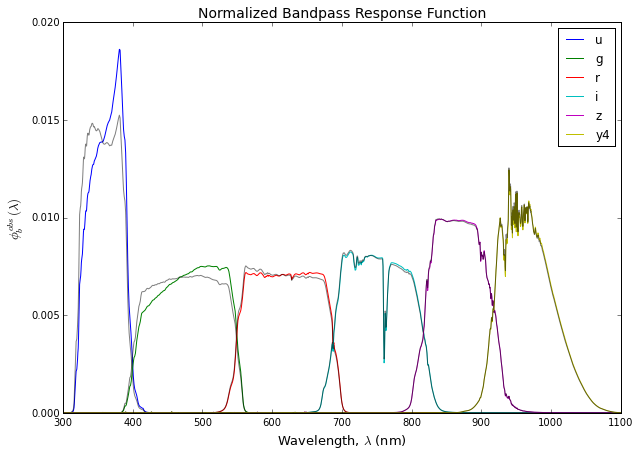

In [27]:
ab.phiPlot(throughput,throughput_std)

AtmoBuilder can also plot the change in normalized bandpass response function:

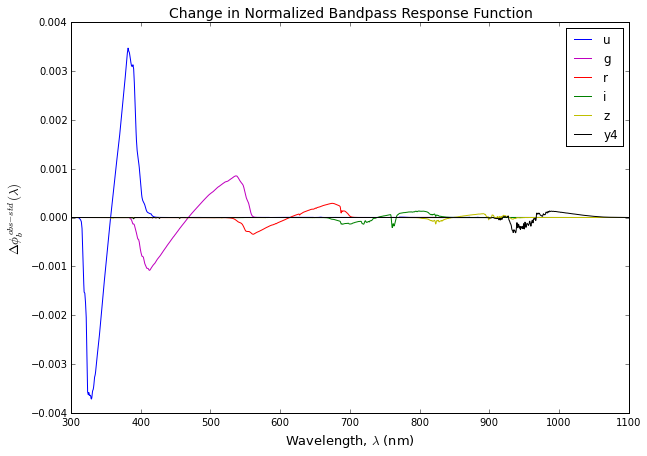

In [28]:
ab.dphiPlot(throughput, throughput_std)

We might want to compare one dphi to another:

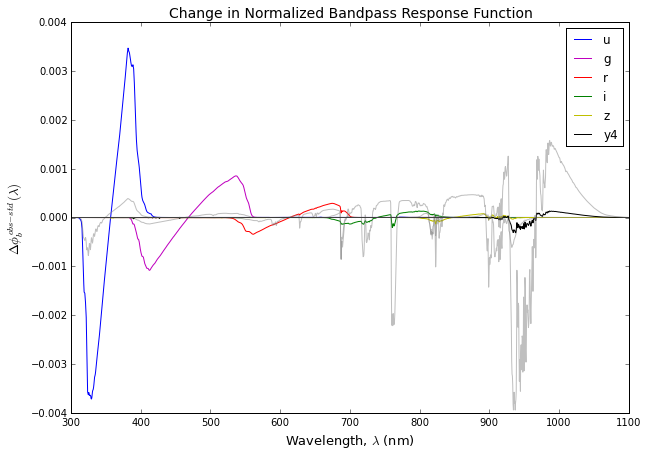

In [29]:
throughput_temp = ab.combineThroughputs(ab.buildAtmo([2.3,2.1,1.2,0.9,1.3,1.8],1.4))
ab.dphiPlot(throughput, throughput_std, throughput_temp)

Sometimes its hard to really see the difference between two phi functions as is often the case when plotting regression data. We can use the ddphiPlot to plot the difference between to dphis in the form of a subtraction between them:

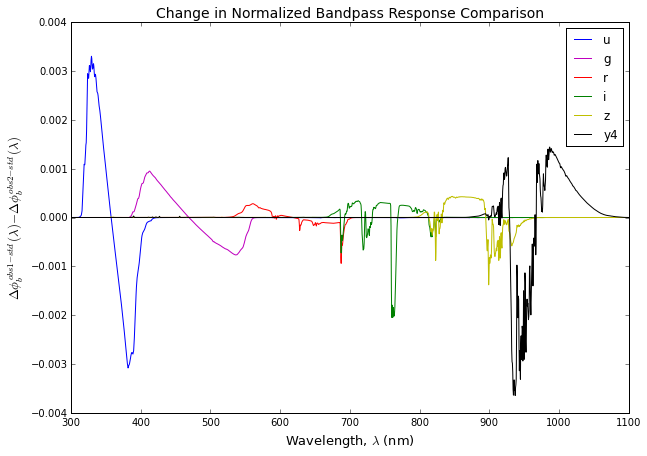

In [30]:
ab.ddphiPlot(throughput,throughput_temp,throughput_std)

Using the throughput we can calculate the magnitudes of stars we read in (defaults to using Kurucz MS SEDs)

In [31]:
mags = ab.mags(throughput)
mags_std = ab.mags(throughput_std)

Or we can calculate the magnitudes and change in magnitudes of other SEDs:

In [46]:
qso_mags = ab.mags(throughput, seds=qso, sedkeylist=qso_z)
qso_mags_std = ab.mags(throughput_std, seds=qso, sedkeylist=qso_z)

In [33]:
dmags = ab.dmags(mags, mags_std)
qso_dmags = ab.dmags(qso_mags, qso_mags_std)

Both mags and dmags are returned as filter-keyed dictionaries of magnitudes:

In [34]:
mags['u']
dmags['u']

array([ -60.23624145,  -60.40850711,  -60.56826628,  -60.74566553,
        -60.91177121,  -61.08369108,  -61.25698367,  -61.99937477,
        -62.66635857,  -63.32696284,  -64.00057702,  -64.66445768,
        -65.33650781,  -66.00255458,  -66.66112892,  -67.33962441,
        -68.01727876,  -68.6850889 ,  -69.34860427,  -69.68886451,
        -69.91999714,  -70.15160595,  -70.38324937,  -70.60231552,
        -70.83213895,  -71.05492611,  -71.28677992,  -71.51070907,
        -71.7345065 ,  -71.95922921,  -72.18802753,  -72.41771601,
        -72.53058874,  -72.72820376,  -72.93014932,  -73.13236806,
        -73.3365557 ,  -73.53354458,  -73.73531972,  -73.94081384,
        -74.13836498,  -74.34397377,  -74.53915899,  -74.73827932,
        -74.94331364,  -75.04396878,  -59.52402359,  -59.69855064,
        -59.87310742,  -60.05510139,  -60.22616867,  -64.55743211,
        -65.23532689,  -65.92165367,  -66.59582782,  -67.27782348,
        -67.96125858,  -68.64347652,  -69.3240451 ,  -69.66348

Suppose we want to see the change in magnitudes between two atmospheres for a single SED type, we can use the following function: 

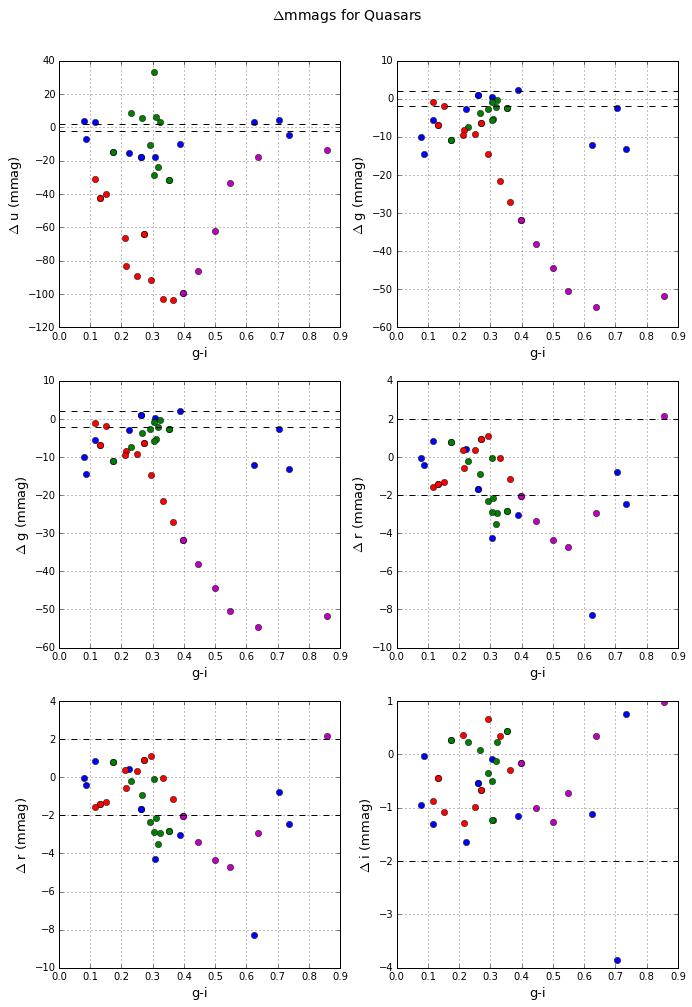

In [35]:
ab.dmagPlot(throughput,throughput_std,'qsos')

Or another SED type example:

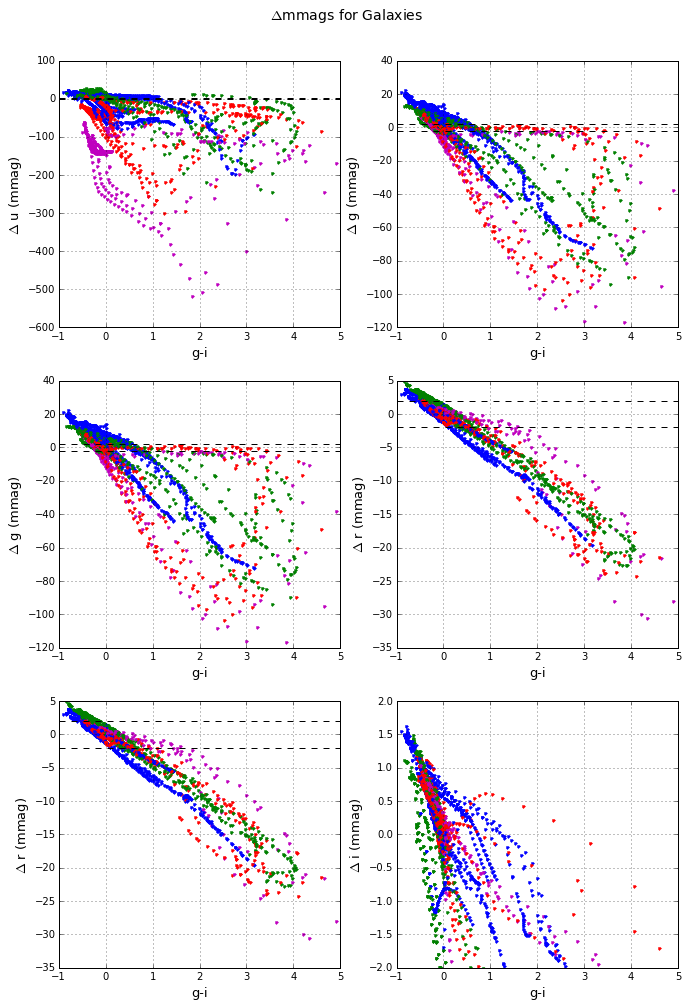

In [36]:
ab.dmagPlot(throughput,throughput_std,'gals')

### Regressions: Two Parameters

Regressions (currently limited to two varying parameters) are the most integral part of AtmoBuilder and are run using a single function. 

In [37]:
ab.computeAtmoFit?

Making use of the atmospheres we created at the beginning of this tutorial, lets run some regressions. Note that we only changed two parameters relative to the standard atmosphere when we created the atmosphere. These were the parameters for the Rayleigh and Aerosol components of atmospheric extinction, so let us regress those two components. (I have added the pickleString keyword argument which saves the pickle dump files and plots with an additional string component in its file name)

Computing nonlinear regression for Rayleigh and Aerosol.
Observed atmosphere parameters: [1.0, 1.0, 1.0, 2.2, 1.4, 1.7]
Observed atmosphere airmass:    1.4
Standard atmosphere parameters: [1.0, 1.0, 1.0, 1.0, 1.0, 1.7]
Standard atmosphere airmass:    1.2
Observed atmosphere parameter for Rayleigh: 2.2
Observed atmosphere parameter for Aerosol: 1.4

Calculating best parameters for u filter...
@pickle_results: using precomputed results from 'pickles/X14_P101010221417_Rayleigh_Aerosol_XSTD12_DG0_E5_mss_u_50b_Tutorial.pkl'
Saved LogL for u filter.
Calculating best parameters for g filter...
@pickle_results: using precomputed results from 'pickles/X14_P101010221417_Rayleigh_Aerosol_XSTD12_DG0_E5_mss_g_50b_Tutorial.pkl'
Saved LogL for g filter.
Calculating best parameters for r filter...
@pickle_results: using precomputed results from 'pickles/X14_P101010221417_Rayleigh_Aerosol_XSTD12_DG0_E5_mss_r_50b_Tutorial.pkl'
Saved LogL for r filter.
Calculating best parameters for i filter...
@pickle_

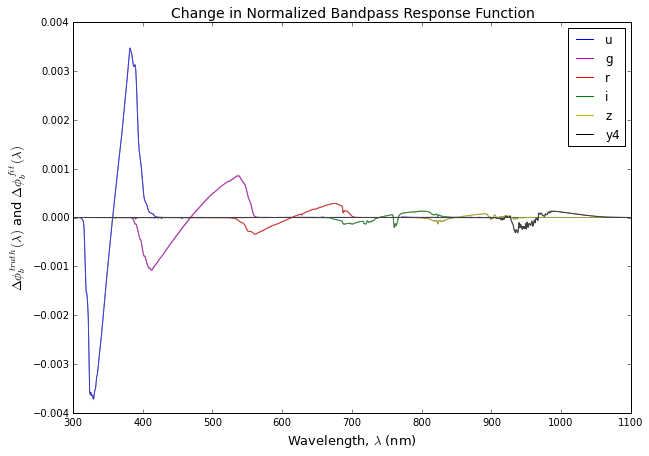

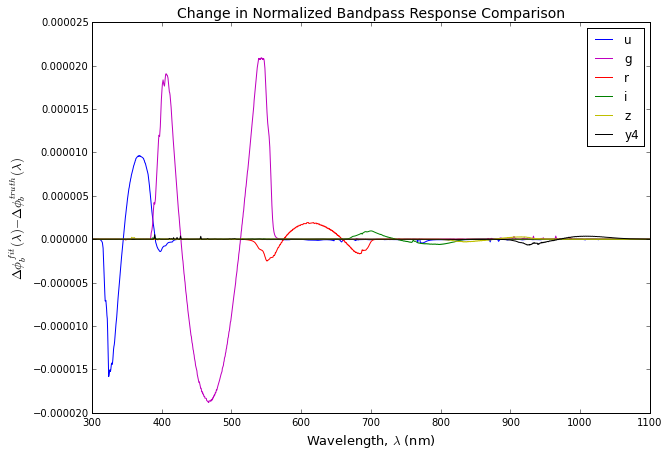

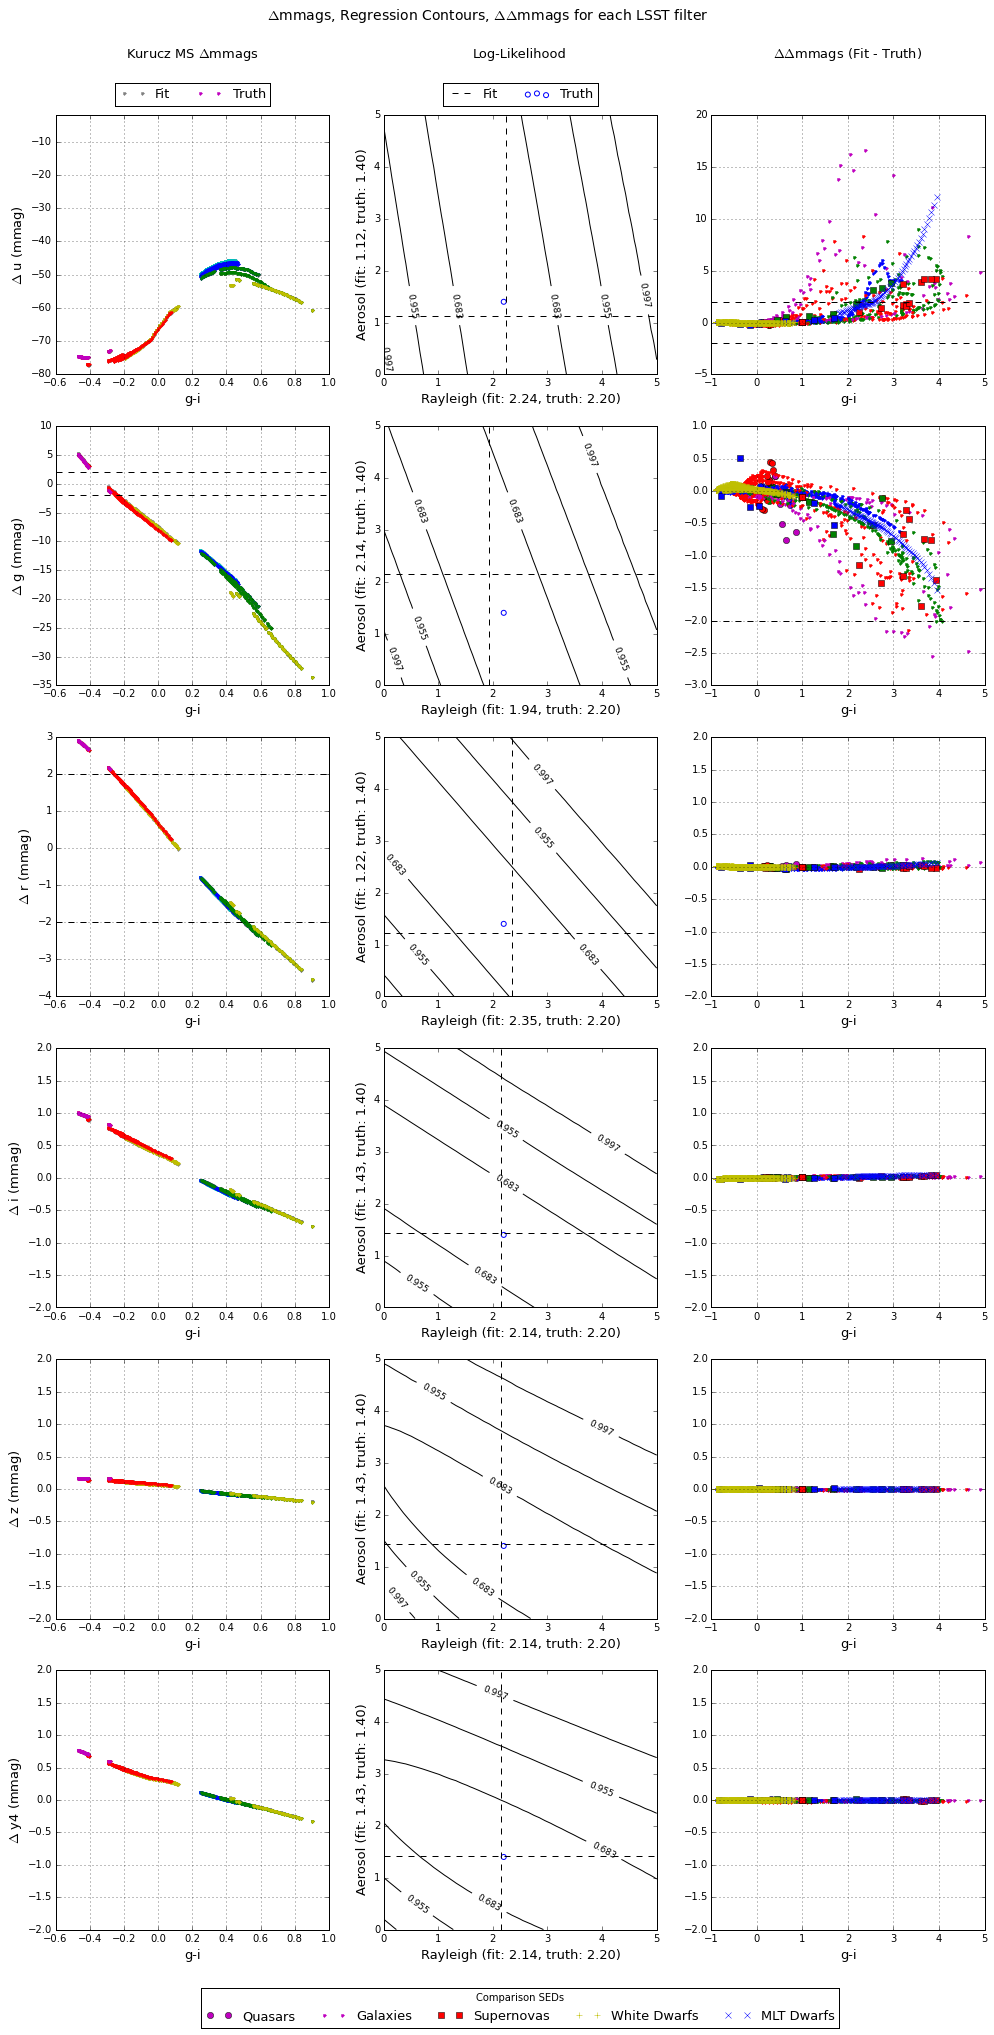

In [47]:
ab.computeAtmoFit('Rayleigh', 'Aerosol', atmo, pickleString='Tutorial')

Sometimes the contour plots do not adequately show the log-likelihood matrix, we can directly plot the logL matrix instead of the regression contours using 'useLogL':

Computing nonlinear regression for Rayleigh and Aerosol.
Observed atmosphere parameters: [1.0, 1.0, 1.0, 2.2, 1.4, 1.7]
Observed atmosphere airmass:    1.4
Standard atmosphere parameters: [1.0, 1.0, 1.0, 1.0, 1.0, 1.7]
Standard atmosphere airmass:    1.2
Observed atmosphere parameter for Rayleigh: 2.2
Observed atmosphere parameter for Aerosol: 1.4

Calculating best parameters for u filter...
@pickle_results: using precomputed results from 'pickles/X14_P101010221417_Rayleigh_Aerosol_XSTD12_DG0_E5_mss_u_50b_Tutorial.pkl'
Saved LogL for u filter.
Calculating best parameters for g filter...
@pickle_results: using precomputed results from 'pickles/X14_P101010221417_Rayleigh_Aerosol_XSTD12_DG0_E5_mss_g_50b_Tutorial.pkl'
Saved LogL for g filter.
Calculating best parameters for r filter...
@pickle_results: using precomputed results from 'pickles/X14_P101010221417_Rayleigh_Aerosol_XSTD12_DG0_E5_mss_r_50b_Tutorial.pkl'
Saved LogL for r filter.
Calculating best parameters for i filter...
@pickle_

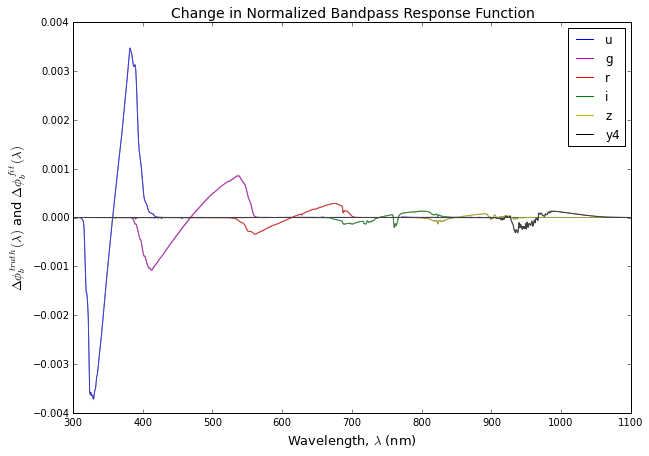

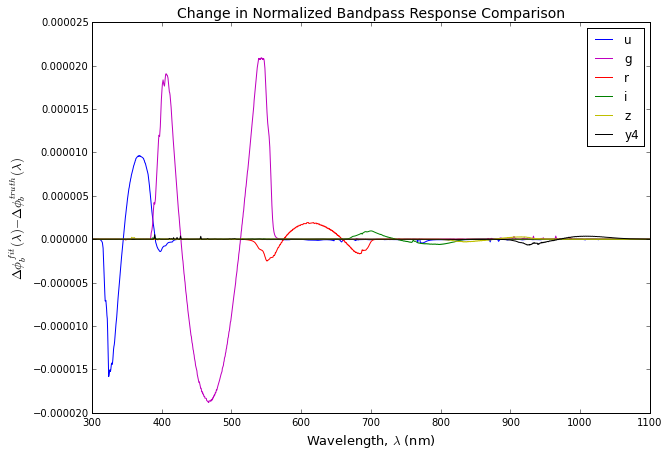

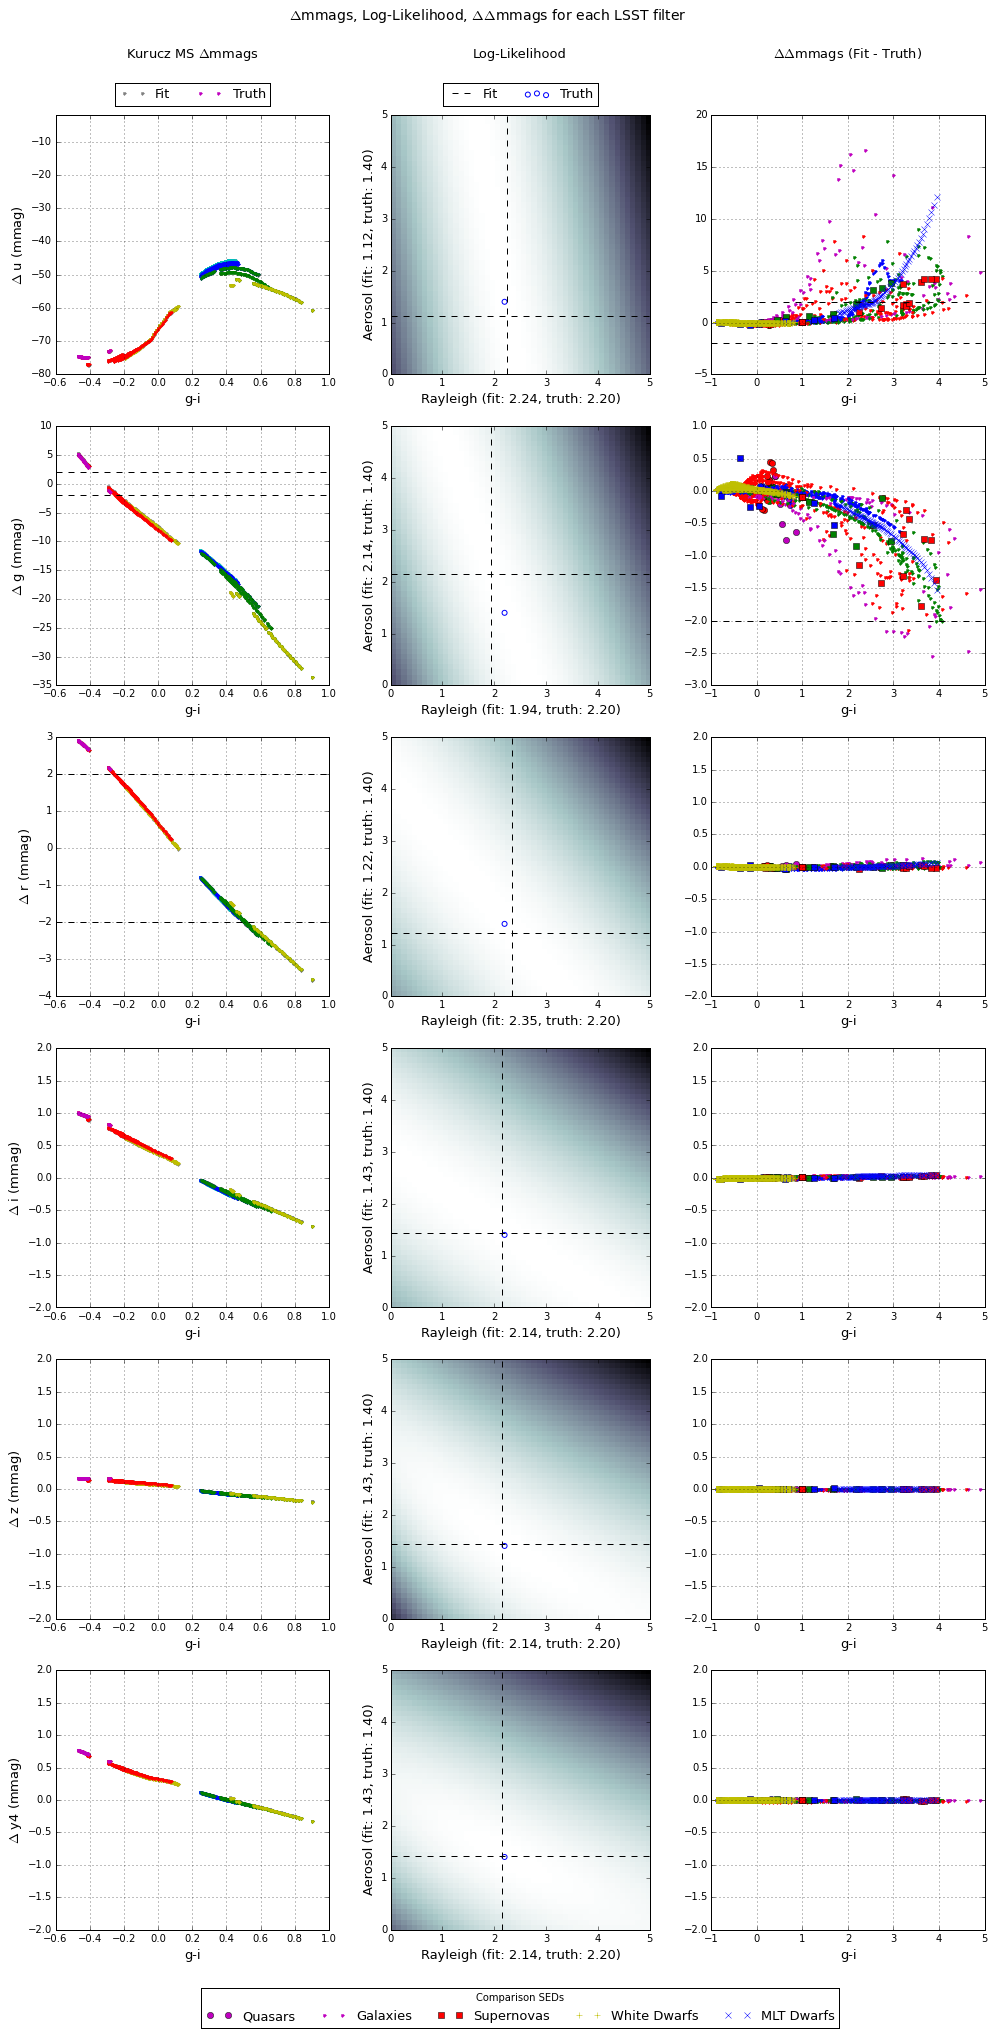

In [39]:
ab.computeAtmoFit('Rayleigh', 'Aerosol', atmo, useLogL=True, pickleString='Tutorial')

A colorbar for the log-likelihood column might be handy and can be included using a keyword argument. Unfortunately, it does resize the middle column slightly. 

Computing nonlinear regression for Rayleigh and Aerosol.
Observed atmosphere parameters: [1.0, 1.0, 1.0, 2.2, 1.4, 1.7]
Observed atmosphere airmass:    1.4
Standard atmosphere parameters: [1.0, 1.0, 1.0, 1.0, 1.0, 1.7]
Standard atmosphere airmass:    1.2
Observed atmosphere parameter for Rayleigh: 2.2
Observed atmosphere parameter for Aerosol: 1.4

Calculating best parameters for u filter...
@pickle_results: using precomputed results from 'pickles/X14_P101010221417_Rayleigh_Aerosol_XSTD12_DG0_E5_mss_u_50b_Tutorial.pkl'
Saved LogL for u filter.
Calculating best parameters for g filter...
@pickle_results: using precomputed results from 'pickles/X14_P101010221417_Rayleigh_Aerosol_XSTD12_DG0_E5_mss_g_50b_Tutorial.pkl'
Saved LogL for g filter.
Calculating best parameters for r filter...
@pickle_results: using precomputed results from 'pickles/X14_P101010221417_Rayleigh_Aerosol_XSTD12_DG0_E5_mss_r_50b_Tutorial.pkl'
Saved LogL for r filter.
Calculating best parameters for i filter...
@pickle_

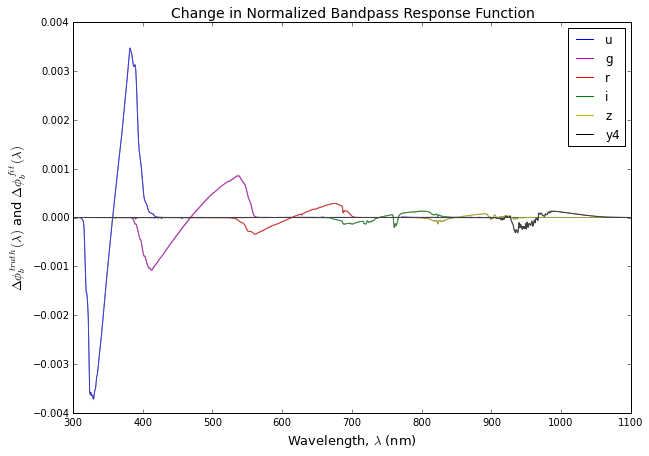

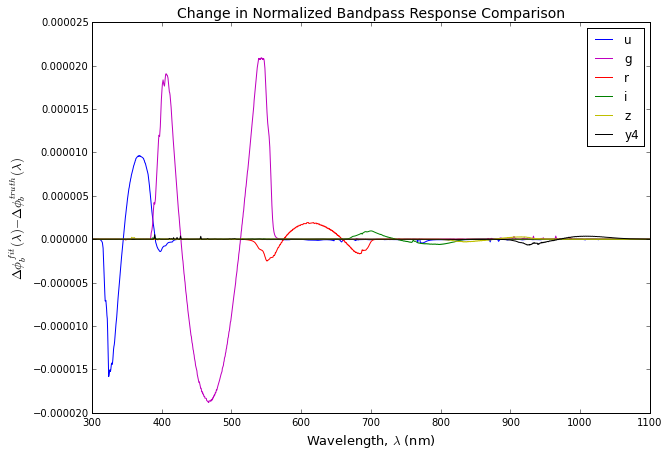

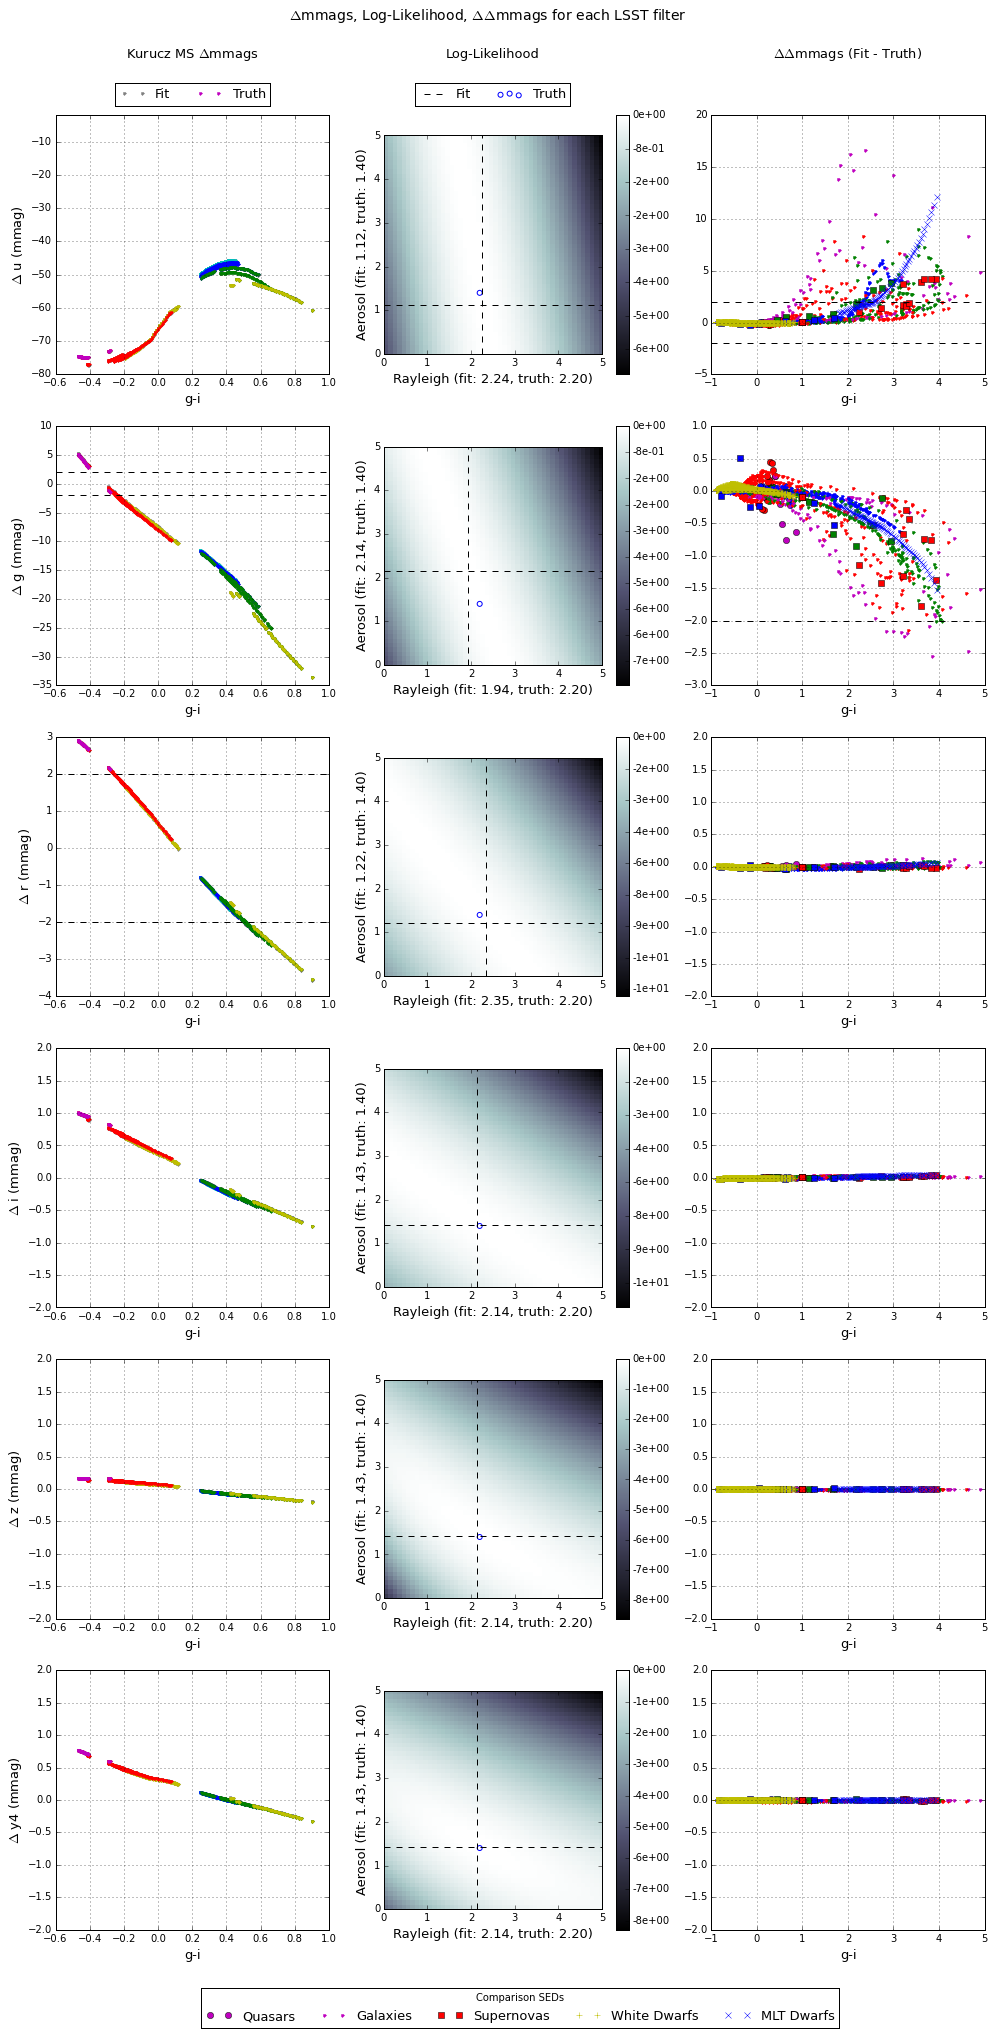

In [40]:
ab.computeAtmoFit('Rayleigh', 'Aerosol', atmo, useLogL=True, includeColorBar=True, pickleString='Tutorial')

By default regressions will run using the Kurucz main sequence star SED data. However, we can also specify a different regression SED: (I have also set generate Dphi to False to condense the notebook a little)

Computing nonlinear regression for Rayleigh and Aerosol.
Observed atmosphere parameters: [1.0, 1.0, 1.0, 2.2, 1.4, 1.7]
Observed atmosphere airmass:    1.4
Standard atmosphere parameters: [1.0, 1.0, 1.0, 1.0, 1.0, 1.7]
Standard atmosphere airmass:    1.2
Observed atmosphere parameter for Rayleigh: 2.2
Observed atmosphere parameter for Aerosol: 1.4

Calculating best parameters for u filter...
@pickle_results: using precomputed results from 'pickles/X14_P101010221417_Rayleigh_Aerosol_XSTD12_DG0_E5_qsos_u_50b_Tutorial.pkl'
Saved LogL for u filter.
Calculating best parameters for g filter...
@pickle_results: using precomputed results from 'pickles/X14_P101010221417_Rayleigh_Aerosol_XSTD12_DG0_E5_qsos_g_50b_Tutorial.pkl'
Saved LogL for g filter.
Calculating best parameters for r filter...
@pickle_results: using precomputed results from 'pickles/X14_P101010221417_Rayleigh_Aerosol_XSTD12_DG0_E5_qsos_r_50b_Tutorial.pkl'
Saved LogL for r filter.
Calculating best parameters for i filter...
@pick

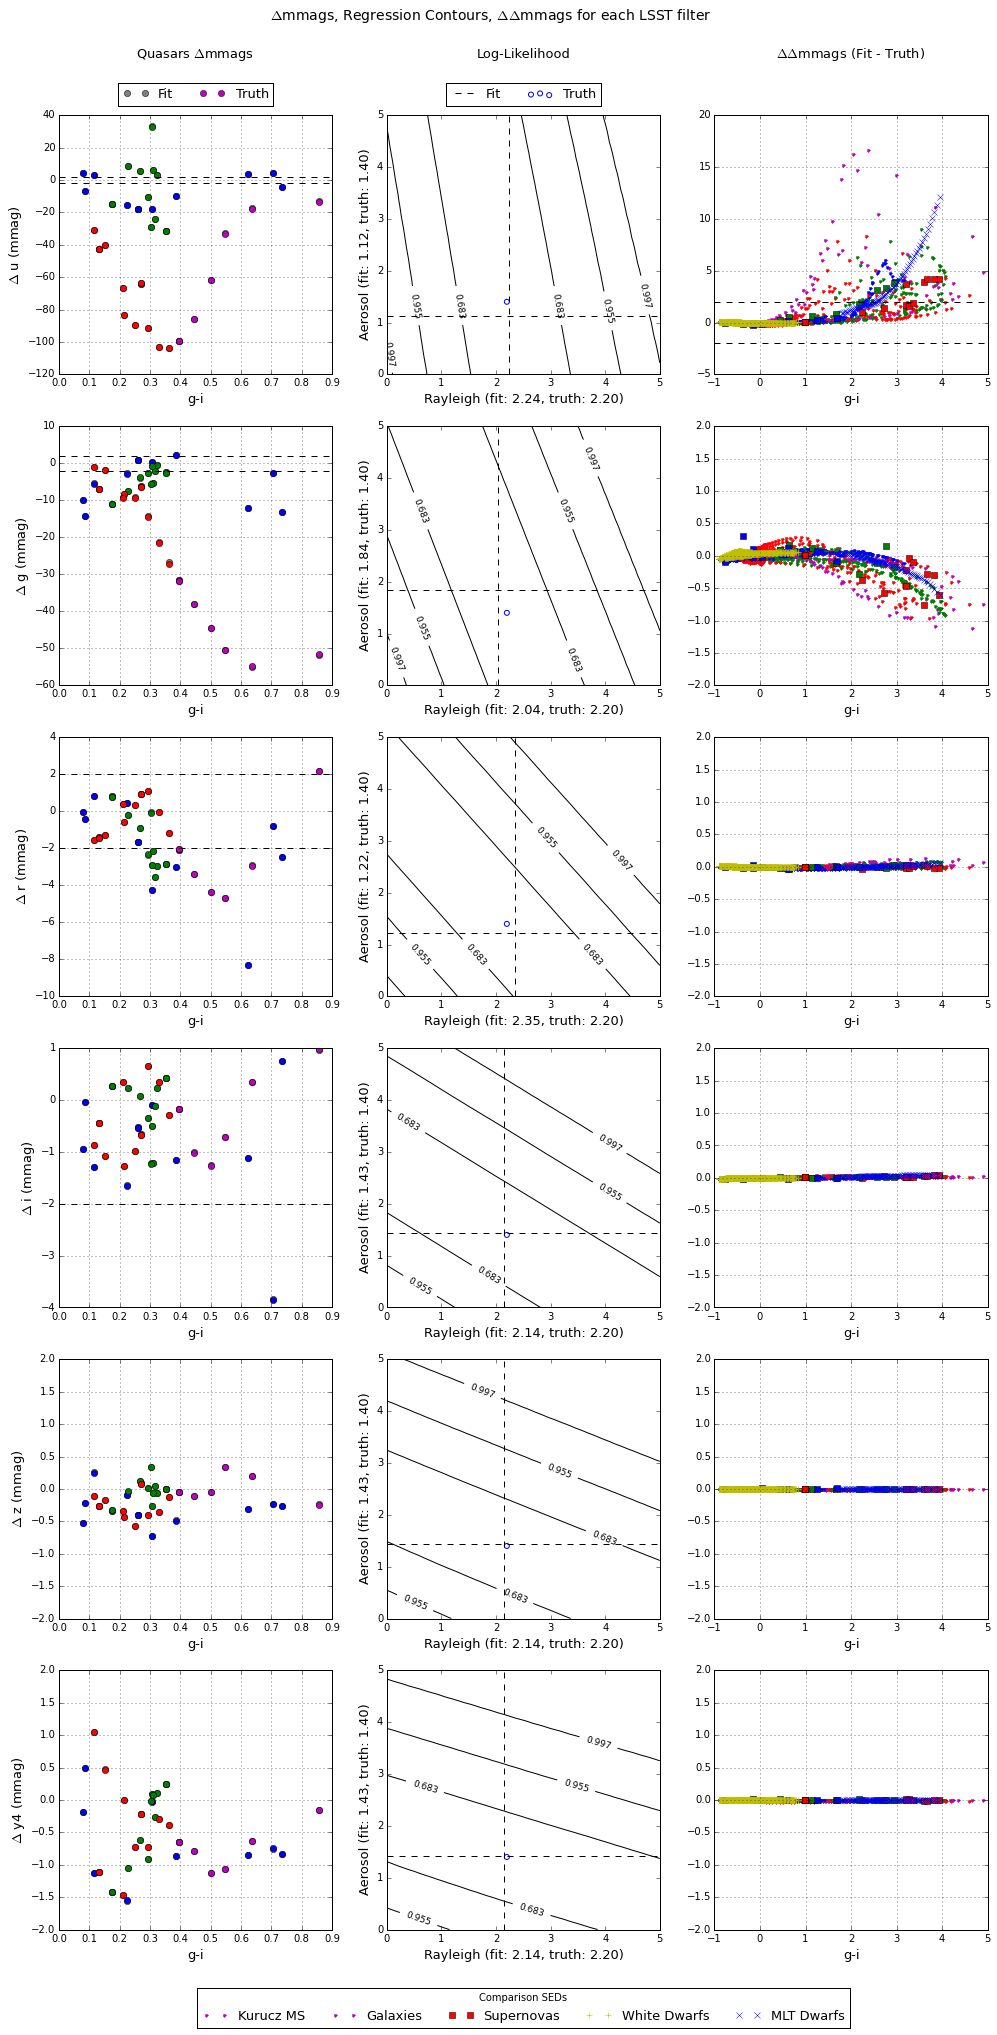

In [41]:
ab.computeAtmoFit('Rayleigh', 'Aerosol', atmo, regressionSed='qsos', generateDphi=False, pickleString='Tutorial')

Like the regression SEDs, we can also set which comparison SEDs to use. By default, computeAtmoFit will always use the remaining SEDs (all of them except the original regression SED).

Computing nonlinear regression for Rayleigh and Aerosol.
Observed atmosphere parameters: [1.0, 1.0, 1.0, 2.2, 1.4, 1.7]
Observed atmosphere airmass:    1.4
Standard atmosphere parameters: [1.0, 1.0, 1.0, 1.0, 1.0, 1.7]
Standard atmosphere airmass:    1.2
Observed atmosphere parameter for Rayleigh: 2.2
Observed atmosphere parameter for Aerosol: 1.4

Calculating best parameters for u filter...
@pickle_results: using precomputed results from 'pickles/X14_P101010221417_Rayleigh_Aerosol_XSTD12_DG0_E5_qsos_u_50b_Tutorial.pkl'
Saved LogL for u filter.
Calculating best parameters for g filter...
@pickle_results: using precomputed results from 'pickles/X14_P101010221417_Rayleigh_Aerosol_XSTD12_DG0_E5_qsos_g_50b_Tutorial.pkl'
Saved LogL for g filter.
Calculating best parameters for r filter...
@pickle_results: using precomputed results from 'pickles/X14_P101010221417_Rayleigh_Aerosol_XSTD12_DG0_E5_qsos_r_50b_Tutorial.pkl'
Saved LogL for r filter.
Calculating best parameters for i filter...
@pick

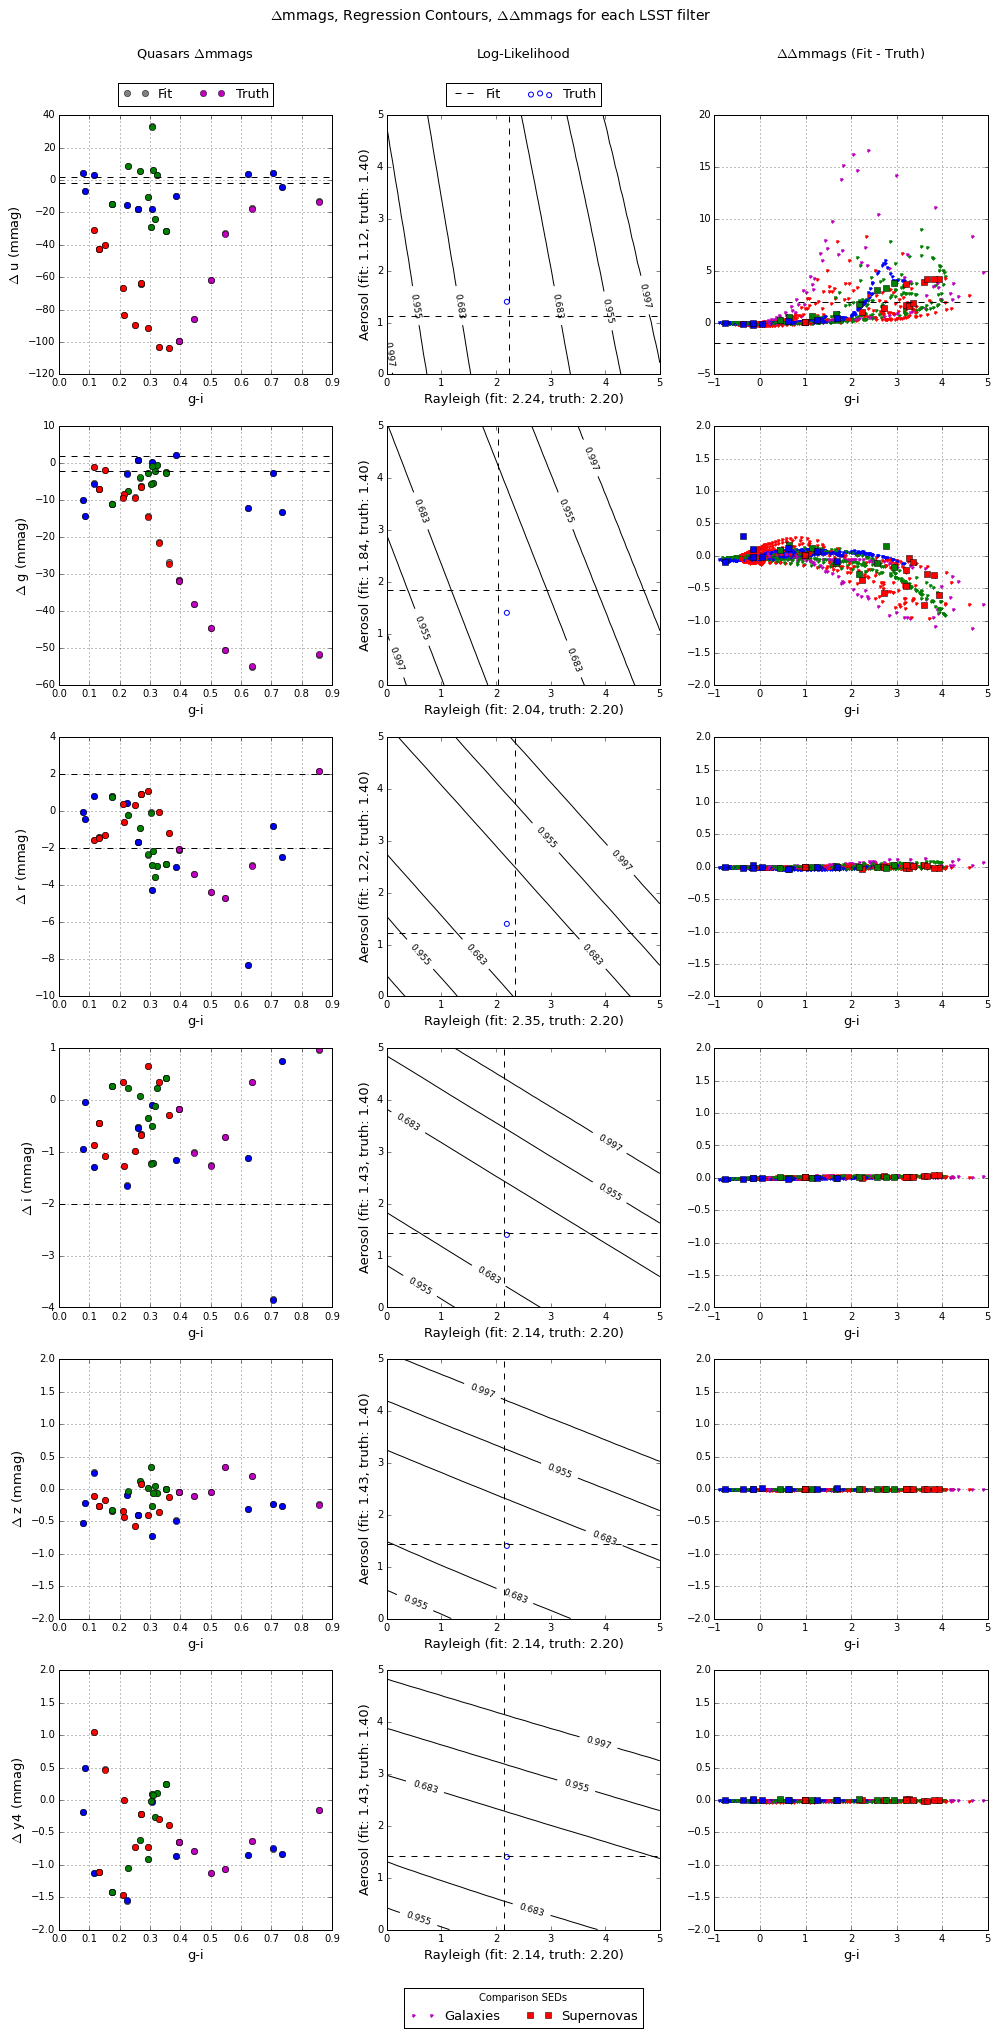

In [42]:
ab.computeAtmoFit('Rayleigh', 'Aerosol', atmo, regressionSed='qsos', comparisonSeds=['gals','sns'], generateDphi=False, pickleString='Tutorial')

The default percent error value for dmags in mmags is set to be 0.5%, however we can also set it to other values. For example, we can set it to be 5%:

Computing nonlinear regression for Rayleigh and Aerosol.
Observed atmosphere parameters: [1.0, 1.0, 1.0, 2.2, 1.4, 1.7]
Observed atmosphere airmass:    1.4
Standard atmosphere parameters: [1.0, 1.0, 1.0, 1.0, 1.0, 1.7]
Standard atmosphere airmass:    1.2
Observed atmosphere parameter for Rayleigh: 2.2
Observed atmosphere parameter for Aerosol: 1.4

Calculating best parameters for u filter...
@pickle_results: using precomputed results from 'pickles/X14_P101010221417_Rayleigh_Aerosol_XSTD12_DG0_E50_mss_u_50b_Tutorial.pkl'
Saved LogL for u filter.
Calculating best parameters for g filter...
@pickle_results: using precomputed results from 'pickles/X14_P101010221417_Rayleigh_Aerosol_XSTD12_DG0_E50_mss_g_50b_Tutorial.pkl'
Saved LogL for g filter.
Calculating best parameters for r filter...
@pickle_results: using precomputed results from 'pickles/X14_P101010221417_Rayleigh_Aerosol_XSTD12_DG0_E50_mss_r_50b_Tutorial.pkl'
Saved LogL for r filter.
Calculating best parameters for i filter...
@pick

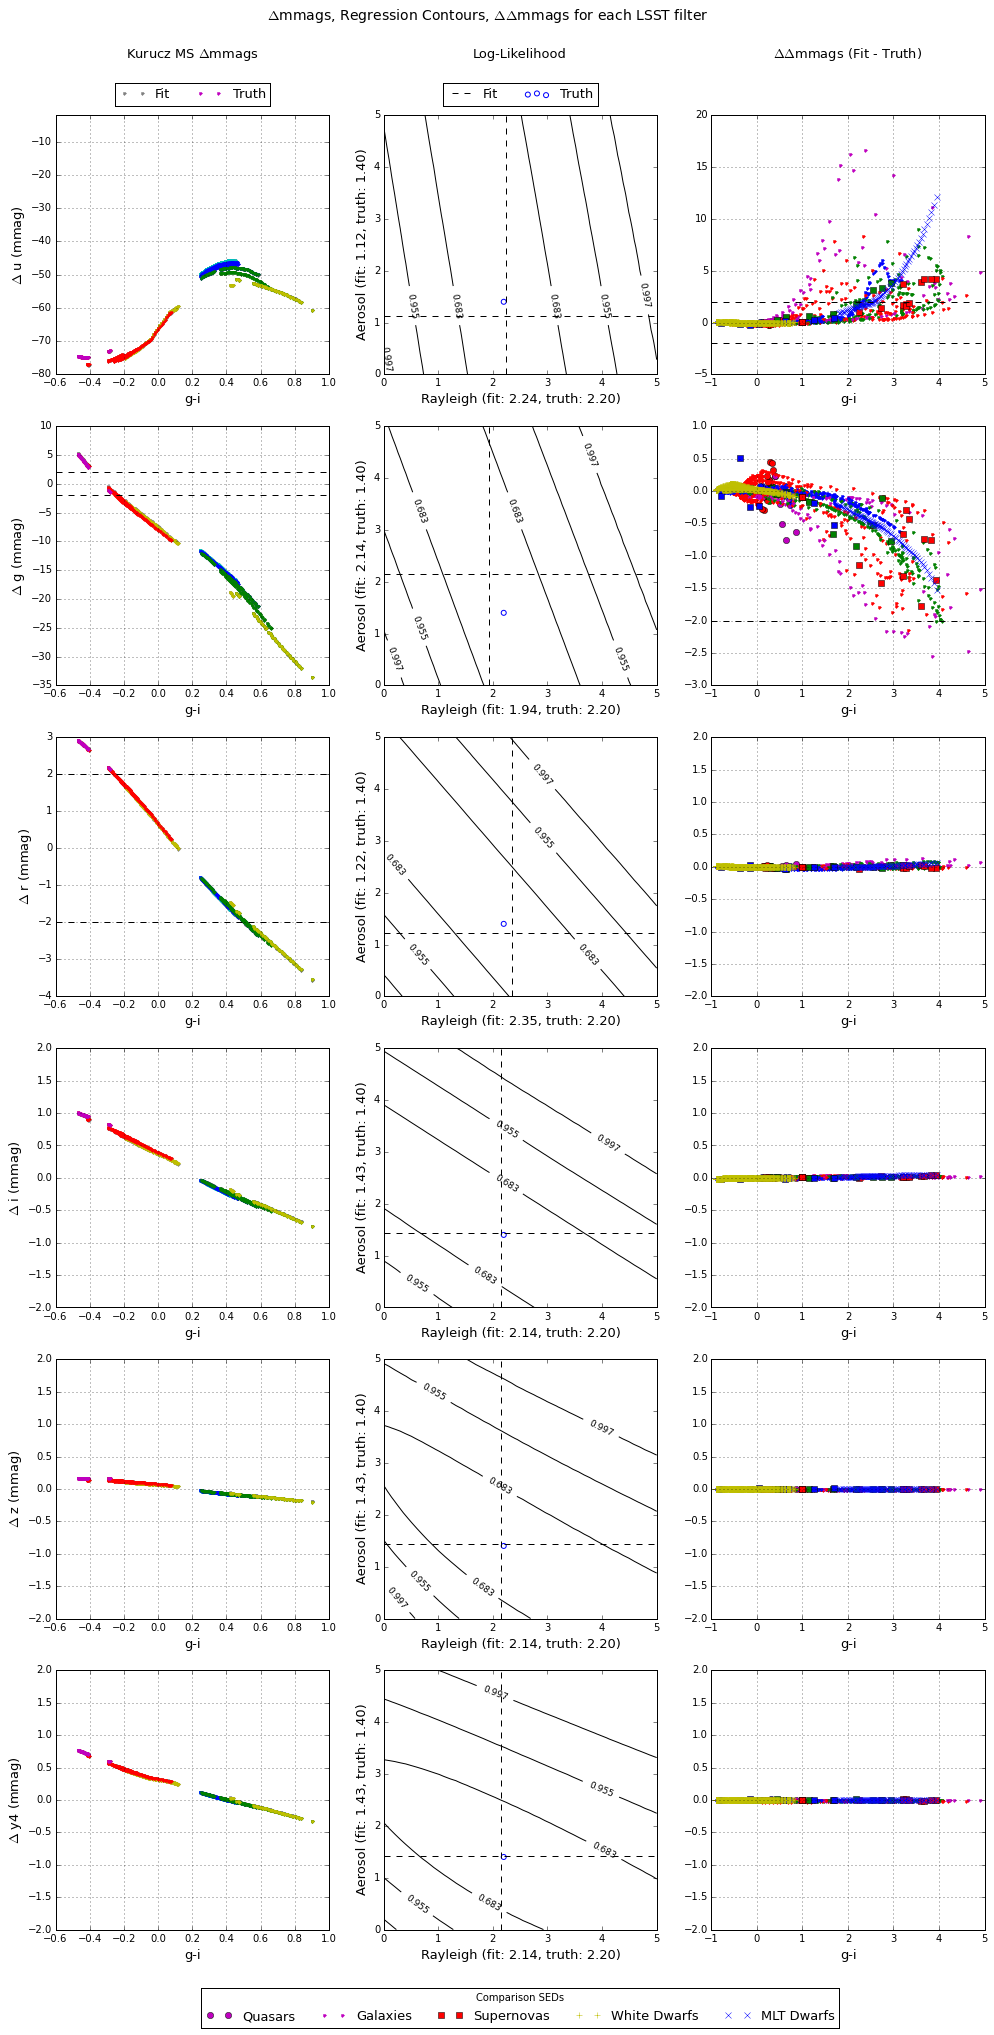

In [43]:
ab.computeAtmoFit('Rayleigh', 'Aerosol', atmo, err=0.05, generateDphi=False, pickleString='Tutorial')

One additional feature of interest is the deltaGrey keyword parameter. It is essentially an additional extinction factor implemented to add some offset representative of cloudy and potentially grey skies.

It works in the following way:
    - deltaGrey = 0.0 : default, no effect
    - deltaGrey >= 0.0 : subtract deltaGrey value from dmags (dG should be in mmags, for example: 20)
    - deltaGrey < 0.0 : subtract median dmag value from dmags

Computing nonlinear regression for Rayleigh and Aerosol.
Observed atmosphere parameters: [1.0, 1.0, 1.0, 2.2, 1.4, 1.7]
Observed atmosphere airmass:    1.4
Standard atmosphere parameters: [1.0, 1.0, 1.0, 1.0, 1.0, 1.7]
Standard atmosphere airmass:    1.2
Observed atmosphere parameter for Rayleigh: 2.2
Observed atmosphere parameter for Aerosol: 1.4

Calculating best parameters for u filter...
@pickle_results: using precomputed results from 'pickles/X14_P101010221417_Rayleigh_Aerosol_XSTD12_DG200_E5_mss_u_50b_Tutorial.pkl'
Saved LogL for u filter.
Calculating best parameters for g filter...
@pickle_results: using precomputed results from 'pickles/X14_P101010221417_Rayleigh_Aerosol_XSTD12_DG200_E5_mss_g_50b_Tutorial.pkl'
Saved LogL for g filter.
Calculating best parameters for r filter...
@pickle_results: using precomputed results from 'pickles/X14_P101010221417_Rayleigh_Aerosol_XSTD12_DG200_E5_mss_r_50b_Tutorial.pkl'
Saved LogL for r filter.
Calculating best parameters for i filter...
@p

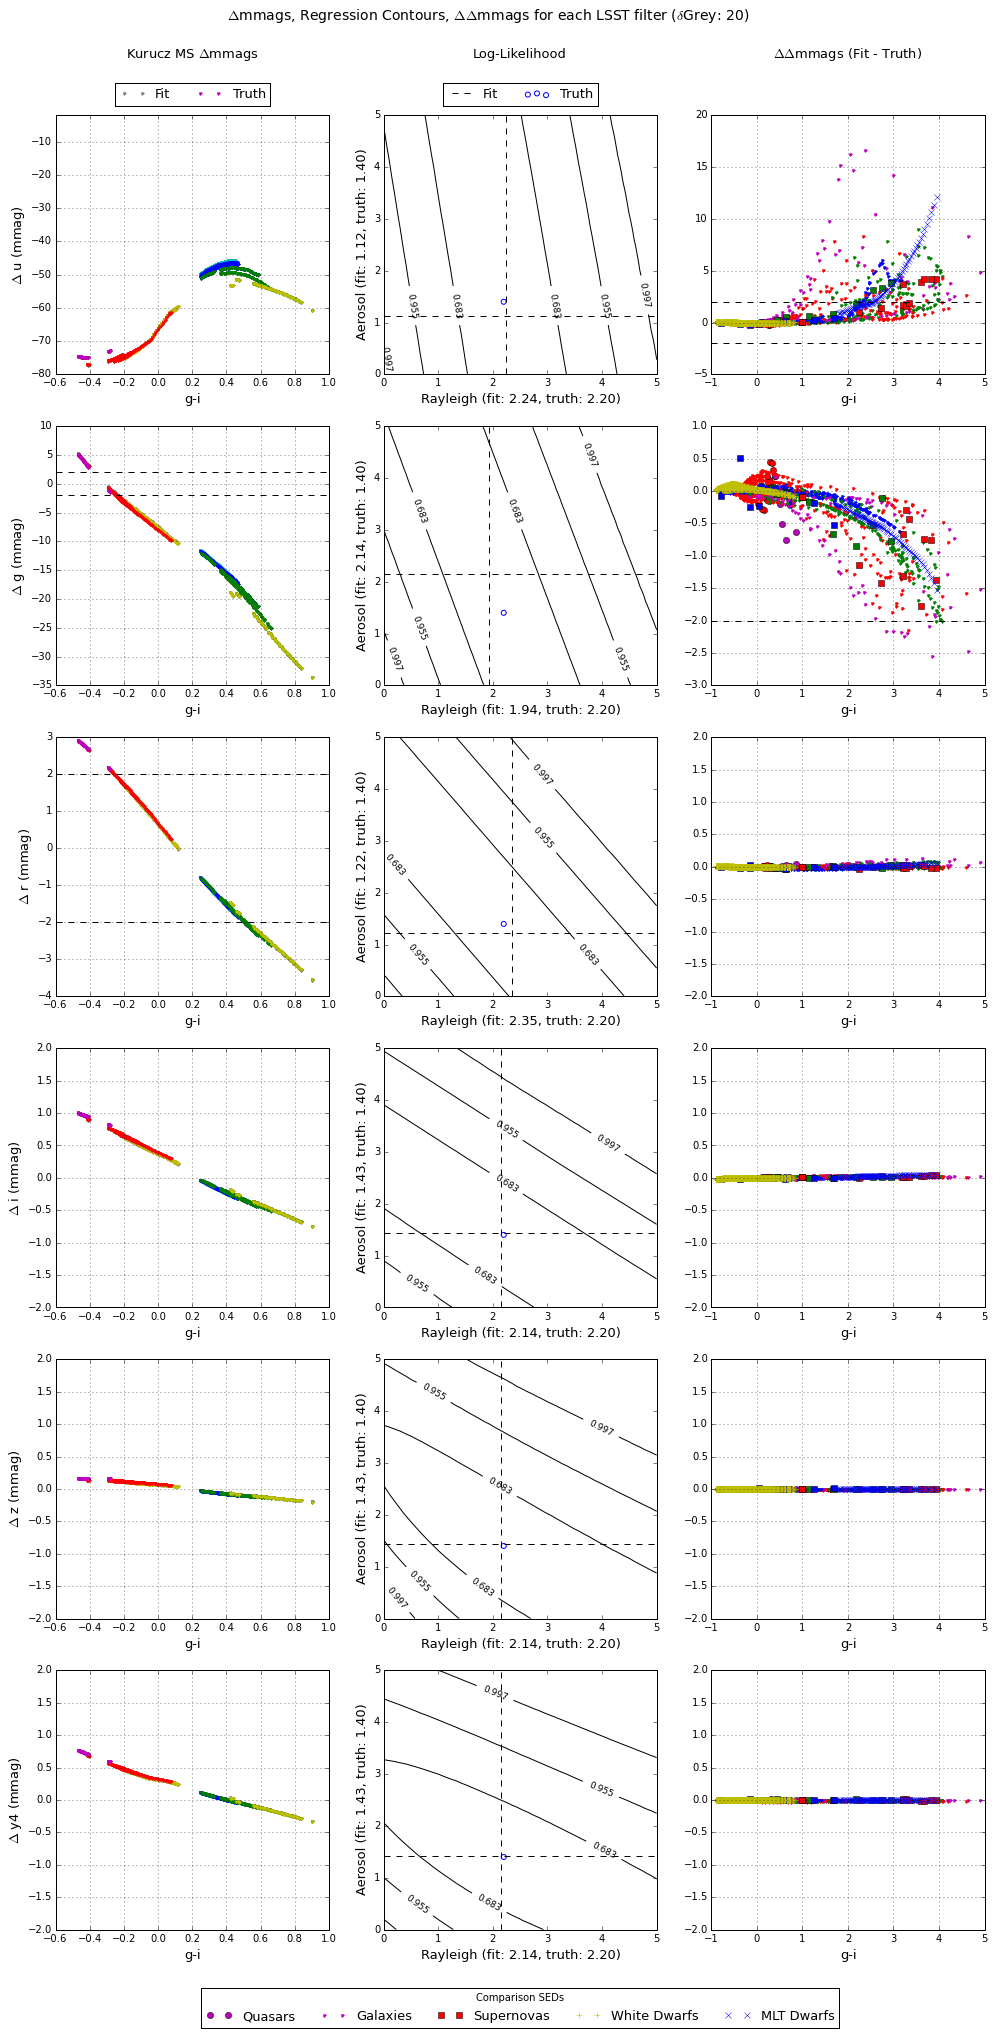

In [44]:
ab.computeAtmoFit('Rayleigh', 'Aerosol', atmo, deltaGrey=20, generateDphi=False, pickleString='Tutorial')

Computing nonlinear regression for Rayleigh and Aerosol.
Observed atmosphere parameters: [1.0, 1.0, 1.0, 2.2, 1.4, 1.7]
Observed atmosphere airmass:    1.4
Standard atmosphere parameters: [1.0, 1.0, 1.0, 1.0, 1.0, 1.7]
Standard atmosphere airmass:    1.2
Observed atmosphere parameter for Rayleigh: 2.2
Observed atmosphere parameter for Aerosol: 1.4

Calculating best parameters for u filter...
@pickle_results: using precomputed results from 'pickles/X14_P101010221417_Rayleigh_Aerosol_XSTD12_DG-10_E5_mss_u_50b_Tutorial.pkl'
Saved LogL for u filter.
Calculating best parameters for g filter...
@pickle_results: using precomputed results from 'pickles/X14_P101010221417_Rayleigh_Aerosol_XSTD12_DG-10_E5_mss_g_50b_Tutorial.pkl'
Saved LogL for g filter.
Calculating best parameters for r filter...
@pickle_results: using precomputed results from 'pickles/X14_P101010221417_Rayleigh_Aerosol_XSTD12_DG-10_E5_mss_r_50b_Tutorial.pkl'
Saved LogL for r filter.
Calculating best parameters for i filter...
@p

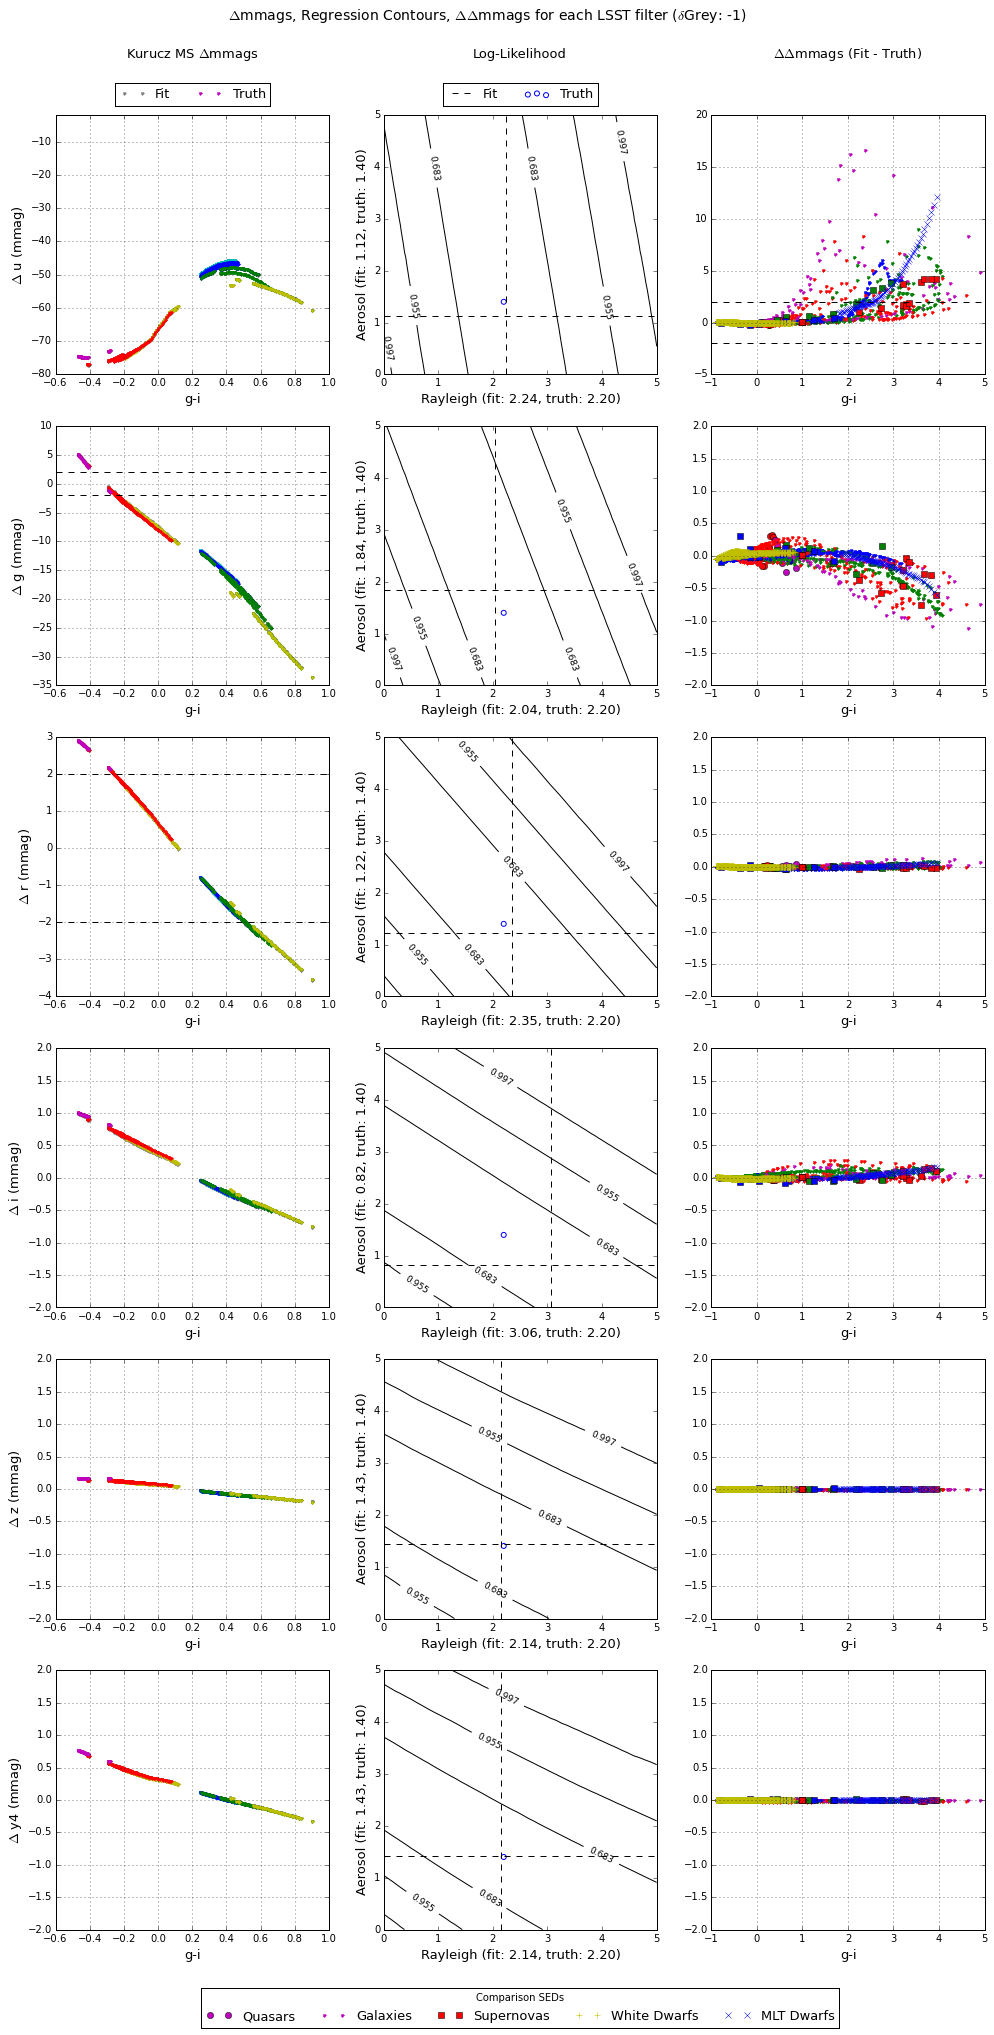

In [45]:
ab.computeAtmoFit('Rayleigh', 'Aerosol', atmo, deltaGrey=-1, generateDphi=False, pickleString='Tutorial')